In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import modin.pandas as pd
import numpy as np
from modin.config import ProgressBar
from tqdm.auto import tqdm

ProgressBar.enable()

In [2]:
# Quick annotation progress check
pd.read_parquet("wforms-ann.parquet")["status"].value_counts(dropna=False)

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2023-07-27 23:33:13,876	INFO worker.py:1636 -- Started a local Ray instance.


Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

status
-1.0    10832
 1.0      370
 NaN      178
 0.0      144
Name: count, dtype: int64

In [3]:
wforms = (
    pd.read_parquet("wforms-bat.parquet")
    .join(pd.read_parquet("wforms-ann.parquet"), how="left")
    .join(pd.read_parquet("wforms-occ.parquet", columns=["rho"]), how="left")
)

stats = [
    [wforms.shape[0], "total"],
    [wforms["fst_batch"].sum(), "1st batch"],
    [wforms["snd_batch"].sum(), "2nd batch"],
    [(wforms["fst_batch"] & wforms["snd_batch"]).sum(), "overlap"],
]

print("Forms statistics:")
for row in stats:
    print("{: >6} {}".format(*row))

del stats

stats = [
    [(~wforms["tt_att"]).sum(), "total"],
    [(~wforms["tt_att"] & wforms["fst_batch"]).sum(), "1st batch"],
    [(~wforms["tt_att"] & wforms["snd_batch"]).sum(), "2nd batch"],
    [(~wforms["tt_att"] & wforms["fst_batch"] & wforms["snd_batch"]).sum(), "overlap"],
]

print("Forms statistics (prefiltered):")
for row in stats:
    print("{: >6} {}".format(*row))

del stats

Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 4:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 9:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 10:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 11:   0%           Elapsed time: 00:00, estimated remaining time: ?

Forms statistics:
925843 total
  6737 1st batch
 21132 2nd batch
   979 overlap


Estimated completion of line 21:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 22:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 23:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 24:   0%           Elapsed time: 00:00, estimated remaining time: ?

Forms statistics (prefiltered):
745121 total
  4296 1st batch
  7906 2nd batch
   678 overlap


In [4]:
# We mark previously attested forms and hashtags as special
wforms.loc[wforms["tt_att"], "status"] = +np.inf
wforms.loc[wforms.index.str.startswith("#"), "status"] = -np.inf

In [5]:
stats = pd.DataFrame(
    {
        "*": wforms["status"].value_counts(dropna=False),
        "1": wforms[wforms["fst_batch"]]["status"].value_counts(dropna=False),
        "2": wforms[wforms["snd_batch"]]["status"].value_counts(dropna=False),
        "1∪2": wforms[wforms["fst_batch"] | wforms["snd_batch"]]["status"].value_counts(
            dropna=False
        ),
        "1∩2": wforms[wforms["fst_batch"] & wforms["snd_batch"]]["status"].value_counts(
            dropna=False
        ),
        "*-a": wforms[~wforms["tt_att"]]["status"].value_counts(dropna=False),
        "1-a": wforms[wforms["fst_batch"]]["status"].value_counts(dropna=False),
        "2-a": wforms[~wforms["tt_att"] & wforms["snd_batch"]]["status"].value_counts(
            dropna=False
        ),
        "1∪2-a": wforms[
            ~wforms["tt_att"] & (wforms["fst_batch"] | wforms["snd_batch"])
        ]["status"].value_counts(dropna=False),
        "1∩2-a": wforms[~wforms["tt_att"] & wforms["fst_batch"] & wforms["snd_batch"]][
            "status"
        ].value_counts(dropna=False),
    }
)

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 4:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 6:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 9:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 12:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 13:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 14:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 18:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 17:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 20:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

In [6]:
stats

,*,1,2,1∪2,1∩2,*-a,1-a,2-a,1∪2-a,1∩2-a
status,,,,,,,,,,
-inf,249076,2422,2621,4619,424,225673.0,2422,1651.0,3391.0,334.0
-1.0,7587,2100,5810,7586,324,7587.0,2100,5810.0,7586.0,324.0
0.0,102,8,95,102,1,102.0,8,95.0,102.0,1.0
1.0,363,99,281,363,17,363.0,99,281.0,363.0,17.0
inf,157319,2093,12256,14138,211,NaN,2093,NaN,NaN,NaN
NaN,511396,15,69,82,2,511396.0,15,69.0,82.0,2.0


In [7]:
gri = wforms[(~wforms["tt_att"]) & wforms["fst_batch"] & (wforms["rho"] > 0.2)][
    "status"
].value_counts(dropna=False)

bfs = wforms[(~wforms["tt_att"]) & wforms["snd_batch"]]["status"].value_counts(
    dropna=False
)

print("Proper grieves breakout (rho>0.2):")
display(gri)
print("Homebrewn breakout:")
display(bfs)

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Proper grieves breakout (rho>0.2):


status
-inf    1352
-1.0    1171
 1.0      74
 0.0       7
 NaN       7
Name: count, dtype: int64

Homebrewn breakout:


status
-1.0    5810
-inf    1651
 1.0     281
 0.0      95
 NaN      69
Name: count, dtype: int64

In [8]:
ProgressBar.disable()

print("\nYield (current 1)")
gri_tot = gri.loc[[1, 0, -1, np.nan]].sum()
bfs_tot = bfs.loc[[1, 0, -1, np.nan]].sum()
gri_yld = gri.loc[1] / gri_tot
bfs_yld = bfs.loc[1] / bfs_tot
print("GRI: {:.3%}".format(gri_yld))
print("BFS: {:.3%}".format(bfs_yld))
print("ADV: {:.0%}".format(bfs_yld / gri_yld - 1))

print("\nYield (current 1+0)")
gri_tot = gri.loc[[1, 0, -1, np.nan]].sum()
bfs_tot = bfs.loc[[1, 0, -1, np.nan]].sum()
gri_yld = gri.loc[[1, 0]].sum() / gri_tot
bfs_yld = bfs.loc[[1, 0]].sum() / bfs_tot
print("GRI: {:.3%}".format(gri_yld))
print("BFS: {:.3%}".format(bfs_yld))
print("ADV: {:.0%}".format(bfs_yld / gri_yld - 1))

print("\nYield (projected 1)")
gri_tot = gri.loc[[1, 0, -1, np.nan]].sum()
bfs_tot = bfs.loc[[1, 0, -1, np.nan]].sum()
gri_yld = gri.loc[1] / gri_tot * (1 + gri.loc[np.nan] / gri_tot)
bfs_yld = bfs.loc[1] / bfs_tot * (1 + bfs.loc[np.nan] / bfs_tot)
print("GRI: {:.3%}".format(gri_yld))
print("BFS: {:.3%}".format(bfs_yld))
print("ADV: {:.0%}".format(bfs_yld / gri_yld - 1))

print("\nYield (projected 1+0)")
gri_tot = gri.loc[[1, 0, -1, np.nan]].sum()
bfs_tot = bfs.loc[[1, 0, -1, np.nan]].sum()
gri_yld = gri.loc[[1, 0]].sum() / gri_tot * (1 + gri.loc[np.nan] / gri_tot)
bfs_yld = bfs.loc[[1, 0]].sum() / bfs_tot * (1 + bfs.loc[np.nan] / bfs_tot)
print("GRI: {:.3%}".format(gri_yld))
print("BFS: {:.3%}".format(bfs_yld))
print("ADV: {:.0%}".format(bfs_yld / gri_yld - 1))

print("\nYield (projected w/ hashes 1)")
gri_tot = gri.loc[[1, 0, -1, np.nan, -np.inf]].sum()
bfs_tot = bfs.loc[[1, 0, -1, np.nan, -np.inf]].sum()
gri_yld = gri.loc[1] / gri_tot * (1 + gri.loc[[np.nan, -np.inf]].sum() / gri_tot)
bfs_yld = bfs.loc[1] / bfs_tot * (1 + bfs.loc[[np.nan, -np.inf]].sum() / bfs_tot)
print("GRI: {:.3%}".format(gri_yld))
print("BFS: {:.3%}".format(bfs_yld))
print("ADV: {:.0%}".format(bfs_yld / gri_yld - 1))

print("\nYield (projected w/ hashes 1+0)")
gri_tot = gri.loc[[1, 0, -1, np.nan, -np.inf]].sum()
bfs_tot = bfs.loc[[1, 0, -1, np.nan, -np.inf]].sum()
gri_yld = (
    gri.loc[[1, 0]].sum() / gri_tot * (1 + gri.loc[[np.nan, -np.inf]].sum() / gri_tot)
)
bfs_yld = (
    bfs.loc[[1, 0]].sum() / bfs_tot * (1 + bfs.loc[[np.nan, -np.inf]].sum() / bfs_tot)
)
print("GRI: {:.3%}".format(gri_yld))
print("BFS: {:.3%}".format(bfs_yld))
print("ADV: {:.0%}".format(bfs_yld / gri_yld - 1))


ProgressBar.enable()


Yield (current 1)
GRI: 5.878%
BFS: 4.492%
ADV: -24%

Yield (current 1+0)
GRI: 6.434%
BFS: 6.011%
ADV: -7%

Yield (projected 1)
GRI: 5.910%
BFS: 4.542%
ADV: -23%

Yield (projected 1+0)
GRI: 6.469%
BFS: 6.078%
ADV: -6%

Yield (projected w/ hashes 1)
GRI: 4.309%
BFS: 4.328%
ADV: 0%

Yield (projected w/ hashes 1+0)
GRI: 4.717%
BFS: 5.791%
ADV: 23%


In [9]:
%%script false --no-raise-error


fig, ax = plt.subplots(3, 2, figsize=(10, 10))

fst_hashfull = wforms[(~wforms["tt_att"]) & wforms["fst_batch"]]["status"].value_counts(
    dropna=False, normalize=True
)
snd_hashfull = wforms[(~wforms["tt_att"]) & wforms["snd_batch"]]["status"].value_counts(
    dropna=False, normalize=True
)
fst_hashless = wforms[
    (~wforms["tt_att"]) & wforms["fst_batch"] & ~wforms.index.str.startswith("#")
]["status"].value_counts(dropna=False, normalize=True)
snd_hashless = wforms[
    (~wforms["tt_att"]) & wforms["snd_batch"] & ~wforms.index.str.startswith("#")
]["status"].value_counts(dropna=False, normalize=True)

fst_hashfull.loc[[+1, 0, -1, -100, np.nan]].plot(
    kind="pie", autopct="%.3f%%", ax=ax[0][0], title="fst (w/ #)"
)


snd_hashfull.loc[[+1, 0, -1, -100, np.nan]].plot(
    kind="pie", autopct="%.3f%%", ax=ax[0][1], title="snd (w/ #)"
)


fst_hashless.loc[[+1, 0, -1, np.nan]].plot(
    kind="pie", autopct="%.3f%%", ax=ax[1][0], title="fst (w/o #)"
)

snd_hashless.loc[[+1, 0, -1, np.nan]].plot(
    kind="pie", autopct="%.3f%%", ax=ax[1][1], title="snd (w/o #)"
)


(
    pd.Series(
        wforms[(~wforms["tt_att"]) & wforms["fst_batch"]].index.str.startswith("#")
    )
    .value_counts()
    .plot(kind="pie", autopct="%.3f%%", ax=ax[2][0], title="fst (# count)")
)

(
    pd.Series(
        wforms[(~wforms["tt_att"]) & wforms["snd_batch"]].index.str.startswith("#")
    )
    .value_counts()
    .plot(kind="pie", autopct="%.3f%%", ax=ax[2][1], title="snd (# count)")
)

plt.tight_layout()
plt.show()

In [10]:
wforms = (
    pd.read_parquet("wforms-bat.parquet")
    .join(pd.read_parquet("wforms-ann.parquet"), how="left")
    .join(pd.read_parquet("wforms-occ.parquet", columns=["rho"]).add_suffix("_occ"), how="left")
    .join(pd.read_parquet("wforms-usr.parquet", columns=["rho"]).add_suffix("_usr"), how="left")
)

print("ρ_o > +0.2 :", ( wforms["rho_occ"] > +0.2 ).sum() )
print("ρ_o < -0.2 :", ( wforms["rho_occ"] < -0.2 ).sum() )

print("", ( ~(abs(wforms["rho_occ"])>0.2) & (abs(wforms["rho_usr"])>0.2) ).sum() )


Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 4:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 8:   0%           Elapsed time: 00:00, estimated remaining time: ?

ρ_o > +0.2 : 4090


Estimated completion of line 9:   0%           Elapsed time: 00:00, estimated remaining time: ?

ρ_o < -0.2 : 2336


Estimated completion of line 11:   0%           Elapsed time: 00:00, estimated remaining time: ?

 311


In [11]:
annos = pd.read_parquet("wforms-ann.parquet")
pars = annos.join(pd.read_parquet("wforms-bat.parquet"), how="left").join(
    pd.read_parquet(
        "wforms-occ.parquet", columns=["fst", "lst", "top", "cvx", "rho", "tot"]
    ),
    how="left",
)

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 4:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 13:   0%           Elapsed time: 00:00, estimated remaining time: ?

(autoscaler +2m42s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +2m42s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +3m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +4m3s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +4m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all

2023-07-27 23:38:58,774	WARNING worker.py:2019 -- WARNING: 112 PYTHON worker processes have been started on node: b6d7748d663c456ac54eba90f0c0a7c6a2a6e90b49d3e99f444a6270 with address: 10.7.19.141. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


(autoscaler +6m3s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +6m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +7m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +8m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2023-07-27 23:41:19,435	WARNING worker.py:2019 -- WARNING: 140 PYTHON worker processes have been started on node: b6d7748d663c456ac54eba90f0c0a7c6a2a6e90b49d3e99f444a6270 with address: 10.7.19.141. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


(autoscaler +8m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +9m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2023-07-27 23:42:41,993	WARNING worker.py:2019 -- WARNING: 174 PYTHON worker processes have been started on node: b6d7748d663c456ac54eba90f0c0a7c6a2a6e90b49d3e99f444a6270 with address: 10.7.19.141. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


(autoscaler +10m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +10m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2023-07-27 23:44:06,881	WARNING worker.py:2019 -- WARNING: 196 PYTHON worker processes have been started on node: b6d7748d663c456ac54eba90f0c0a7c6a2a6e90b49d3e99f444a6270 with address: 10.7.19.141. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


(autoscaler +11m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +12m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +12m45s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2023-07-27 23:46:27,680	WARNING worker.py:2019 -- WARNING: 224 PYTHON worker processes have been started on node: b6d7748d663c456ac54eba90f0c0a7c6a2a6e90b49d3e99f444a6270 with address: 10.7.19.141. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


(autoscaler +13m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +14m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +14m45s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +15m26s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2023-07-27 23:48:48,428	WARNING worker.py:2019 -- WARNING: 252 PYTHON worker processes have been started on node: b6d7748d663c456ac54eba90f0c0a7c6a2a6e90b49d3e99f444a6270 with address: 10.7.19.141. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


(autoscaler +16m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +16m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +17m26s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2023-07-27 23:51:09,072	WARNING worker.py:2019 -- WARNING: 280 PYTHON worker processes have been started on node: b6d7748d663c456ac54eba90f0c0a7c6a2a6e90b49d3e99f444a6270 with address: 10.7.19.141. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


(autoscaler +18m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2023-07-27 23:51:38,160	WARNING worker.py:2019 -- WARNING: 308 PYTHON worker processes have been started on node: b6d7748d663c456ac54eba90f0c0a7c6a2a6e90b49d3e99f444a6270 with address: 10.7.19.141. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2023-07-27 23:53:57,001	WARNING worker.py:2019 -- WARNING: 336 PYTHON worker processes have been started on node: b6d7748d663c456ac54eba90f0c0a7c6a2a6e90b49d3e99f444a6270 with address: 10.7.19.141. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


(autoscaler +22m52s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2023-07-27 23:56:17,894	WARNING worker.py:2019 -- WARNING: 364 PYTHON worker processes have been started on node: b6d7748d663c456ac54eba90f0c0a7c6a2a6e90b49d3e99f444a6270 with address: 10.7.19.141. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


(autoscaler +23m32s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2023-07-27 23:57:38,396	WARNING worker.py:2019 -- WARNING: 434 PYTHON worker processes have been started on node: b6d7748d663c456ac54eba90f0c0a7c6a2a6e90b49d3e99f444a6270 with address: 10.7.19.141. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
*** SIGTERM received at time=1690506905 on cpu 24 ***
PC: @     0x7f3a97e2300c  (unknown)  _PyEval_EvalFrameDefault
    @     0x7f3a97bc0520  (unknown)  (unknown)
    @ ... and at least 96 more frames
[2023-07-28 01:15:05,570 E 681304 681304] logging.cc:361: *** SIGTERM received at time=1690506905 on cpu 24 ***
[2023-07-28 01:15:05,570 E 681304 681304] logging.cc:361: PC: @     0x7f3a97e2300c  (unknown)  _PyEval_EvalFrameDefault
[2023-07-28 01:15:05,570 E 681304 681304] logging.cc:361:     @     0x7f3a97bc0520  (unknown)  (unknown)
[2023-07-28 01:15:05,570 E 681304 681304] logging.cc:361:     @ ... and at

SystemExit: 15

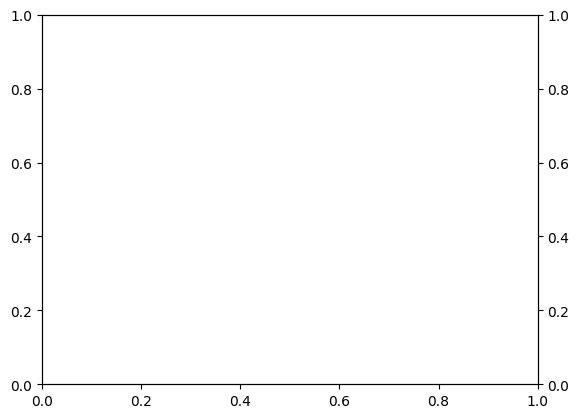

In [12]:
rho_thresholdsp = pd.Series(np.linspace(0.2, 1, 50))
rho_thresholdsn = pd.Series(np.linspace(-1, -0.2, 50))

testp = pars[pars["fst_batch"] & (pars["rho"] > 0.2)]
testn = pars[pars["fst_batch"] & (pars["rho"] < -0.2)]


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(
    rho_thresholdsp,
    rho_thresholdsp.apply(lambda t: (testp["rho"] >= t).sum()),
    color="red",
)

ax2.plot(
    rho_thresholdsp,
    rho_thresholdsp.apply(
        lambda t: ((testp["rho"] >= t) & testp["status"].eq(1)).mean()
    ),  # /rho_thresholdsp.apply(lambda t: (testp["rho"] >= t).sum()),
)


ax1.plot(
    rho_thresholdsn,
    rho_thresholdsn.apply(lambda t: (testn["rho"] <= t).sum()),
    color="red",
)

ax2.plot(
    rho_thresholdsn,
    rho_thresholdsn.apply(
        lambda t: ((testn["rho"] <= t) & testn["status"].eq(1)).mean()
    ),  # /rho_thresholdsn.apply(lambda t: (testn["rho"] <= t).sum()),
)


fig.tight_layout()
plt.show()

In [ ]:
fst_thresholds = pd.Series(np.arange(7, 366, 5))
lst_thresholds = pd.Series(np.arange(351, 366))

testf = pars[pars["snd_batch"] & (pars["fst"] > 7)]
testl = pars[pars["snd_batch"] & (pars["lst"] > 351)]


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(
    fst_thresholds,
    fst_thresholds.apply(lambda t: (testf["fst"] >= t).sum()),
    color="red",
)

ax2.plot(
    fst_thresholds,
    fst_thresholds.apply(
        lambda t: ((testf["fst"] >= t) & testf["status"].eq(1)).mean()
    ),  # /fst_thresholds.apply(lambda t: (testf["fst"] >= t).sum()),
)


ax1.plot(
    lst_thresholds,
    lst_thresholds.apply(lambda t: (testl["lst"] >= t).sum()),
    color="red",
)

ax2.plot(
    lst_thresholds,
    lst_thresholds.apply(
        lambda t: ((testl["lst"] >= t) & testl["status"].eq(1)).mean()
    ),  # /lst_thresholds.apply(lambda t: (testl["lst"] >= t).sum()),
)


fig.tight_layout()
plt.show()

In [ ]:
thresholds = pd.Series(np.linspace(-1, +1, 20))

test = pars[pars["snd_batch"] & ~pars["cvx"].isna()]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(
    thresholds,
    thresholds.apply(lambda t: (test["cvx"] <= t).sum()),
    color="red",
)

ax2.plot(
    thresholds,
    thresholds.apply(lambda t: ((test["cvx"] <= t) & test["status"].eq(1)).mean()),
    color="blue",
    label="yield",
)

plt.legend()

fig.tight_layout()
plt.show()

In [ ]:
thresholds = pd.Series(np.linspace(-1, +1, 20))

test = pars[pars["snd_batch"] & ~pars["cvx"].isna()]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(
    thresholds,
    thresholds.apply(lambda t: (test["cvx"] >= t).sum()),
    color="red",
)

ax2.plot(
    thresholds,
    thresholds.apply(lambda t: ((test["cvx"] >= t) & test["status"].eq(1)).mean()),
    color="blue",
    label="yield",
)

plt.legend()

fig.tight_layout()
plt.show()

In [ ]:
thresholds = pd.Series(np.linspace(0, +1, 100))

test = pars[pars["snd_batch"] & ~pars["cvx"].isna()]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(
    thresholds,
    thresholds.apply(lambda t: (abs(test["cvx"]) <= t).sum()),
    color="red",
)

ax2.plot(
    thresholds,
    thresholds.apply(lambda t: ((abs(test["cvx"]) <= t) & test["status"].eq(1)).mean())
    / thresholds.apply(lambda t: (abs(test["cvx"]) <= t).sum()),
    color="blue",
    label="yield",
)

plt.legend()

fig.tight_layout()
plt.show()